# Sentiment Analysis Research and Application
## Transformer with subword tokenization
## by raja batra and eli rejto

This notebook goes over the process of preprocessing the sentiment 140 dataset with 1.6 million labeled tweets. Then we build a transformer model and train the model using subwordtokenization to predict the sentiment of tweets.

I will use subword tokenization to be the input to my transformer:
Using the Hugging face tutorial (https://huggingface.co/learn/nlp-course/chapter6/8?fw=pt)


Subword tokenization algorithms rely on the principle that frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords. For instance "annoyingly" might be considered a rare word and could be decomposed into "annoying" and "ly". Both "annoying" and "ly" as stand-alone subwords would appear more frequently while at the same time the meaning of "annoyingly" is kept by the composite meaning of "annoying" and "ly". This is especially useful in agglutinative languages such as Turkish, where you can form (almost) arbitrarily long complex words by stringing together subwords.

Subword tokenization allows the model to have a reasonable vocabulary size while being able to learn meaningful context-independent representations. In addition, subword tokenization enables the model to process words it has never seen before, by decomposing them into known subwords. For instance, the BertTokenizer tokenizes "I have a new GPU!" as follows:

In [1]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.tokenize("I have a new GPU!")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

['i', 'have', 'a', 'new', 'gp', '##u', '!']

In [2]:
import torch
import math
import re
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from torch import nn, optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torchtext
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import one_hot
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


check gpu

In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## The data we are using is Sentiment 140 from kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140

In [5]:
csvfile = '/content/drive/MyDrive/twitter.csv'

In [6]:

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

kaggledataset = pd.read_csv(csvfile,
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [7]:
# Removing the unnecessary columns.
kaggledataset = kaggledataset[['sentiment','text']]
# Replacing the values to ease understanding.
kaggledataset['sentiment'] = kaggledataset['sentiment'].replace(4,1)

I will train a tokeninzer from scratch. Using the hugging face example as a guide: https://github.com/huggingface/notebooks/blob/main/examples/tokenizer_training.ipynb

In [8]:
from transformers.utils import send_example_telemetry

send_example_telemetry("tokenizer_training_notebook", framework="none")

In [9]:
pip install datasets transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00


In [10]:
from datasets import load_dataset

In [11]:
#using wikitext
dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [12]:
dataset

Dataset({
    features: ['text'],
    num_rows: 36718
})

In [13]:
batch_size = 1000
all_texts = [dataset[i : i + batch_size]["text"] for i in range(0, len(dataset), batch_size)]

In [14]:
def batch_iterator():
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]["text"]

In [15]:
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

normalize text by lowercasing it and applying the bertpretokenizer

In [16]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)

In [17]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

In [18]:
tokenizer.pre_tokenizer.pre_tokenize_str("This is an example!")

[('This', (0, 4)),
 ('is', (5, 7)),
 ('an', (8, 10)),
 ('example', (11, 18)),
 ('!', (18, 19))]

add special tokens including starting and ending sentences, masking tokens, and unknown words

In [19]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

In [20]:
tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)

In [21]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

2 3


In [22]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", cls_token_id),
        ("[SEP]", sep_token_id),
    ],
)
tokenizer.decoder = decoders.WordPiece(prefix="##")

now i test the tokenizer

In [23]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.', '[SEP]']


In [24]:
tokenizer.save("customtokenizer.json")

Now i will use my custom subword tokenizer on my data

In [25]:
customtokenizer = Tokenizer.from_file("/content/customtokenizer.json")

In [26]:
def preprocess(text_list, tokenizer):
    processed_data = []
    for text in text_list:
        # Tokenize text using the custom tokenizer
        tokens = tokenizer.encode(text).tokens
        processed_data.append(tokens)
    return processed_data

In [27]:
import time
text, sentiment = list(kaggledataset['text']), list(kaggledataset['sentiment'])

t = time.time()
# Preprocess text using your custom tokenizer
processed_text = preprocess(text, customtokenizer)


print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 144 seconds


In [28]:
vocab = customtokenizer.get_vocab()

print(len(vocab))

25000


In [29]:
print(vocab['[CLS]'])

2


In [30]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, vocab, tokenizer, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        # Convert text to numerical indices using the vocabulary
        #numerical_indices = tokenizer.token_to_id(text)
        numerical_indices = [tokenizer.token_to_id(word) for word in text]
        numerical_indices =torch.as_tensor(numerical_indices, dtype=torch.long)

        # Convert label to one-hot encoding
        one_hot_label = one_hot(torch.as_tensor(label, dtype=torch.long), num_classes=2)

        sample = {'data': numerical_indices, 'label': one_hot_label}

        if self.transform:
            sample = self.transform(sample)

        return sample

Build a dataset with processed text and labels

In [31]:
twitterdataset = CustomDataset(data=processed_text, labels=sentiment, vocab= vocab, tokenizer = customtokenizer)

In [32]:
data = twitterdataset.data
labels = twitterdataset.labels


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# Further split the test set into validation and test sets
validation_data, test_data, validation_labels, test_labels = train_test_split(
    test_data, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)

In [33]:
print(train_data[10])

['[CLS]', 'i', 'am', 'home', 'and', 'my', 'throat', 'is', 'killing', 'me', '!', 'i', 'need', 'to', 'cook', '.', '.', '.', 'and', 'work', 'out', '.', '.', '.', 'and', 'clean', '.', '.', '.', 'and', 'show', '##er', '.', '.', '.', 'apply', 'for', 'intern', '##ships', '.', '.', '.', 'busy', 'busy', 'me', '[SEP]']


In [34]:
def collate_fn(batch):
    data = [torch.tensor(item['data']) for item in batch]
    label = [item['label'] for item in batch]

    # Pad sequences to the length of the longest sequence in the batch
    data_padded = pad_sequence(data, batch_first=True, padding_value=0)

    # Stack one-hot encoded labels
    label_stacked = torch.stack(label, dim=0)

    return {'data': data_padded, 'label': label_stacked}

In [35]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataset = CustomDataset(train_data, train_labels, vocab, customtokenizer)
validation_dataset = CustomDataset(validation_data, validation_labels, vocab, customtokenizer)
test_dataset = CustomDataset(test_data, test_labels, vocab, customtokenizer)

# Calculate the number of samples to use (20% of the dataset)
trainnum_samples = int(0.2 * len(train_dataset))
valnum_samples = int(0.2 * len(validation_dataset))
testnum_samples = int(0.2 * len(test_dataset))

# Create indices for the subset
trainindices = torch.randperm(len(train_dataset))[:trainnum_samples]
valindices = torch.randperm(len(validation_dataset))[:valnum_samples]
testindices = torch.randperm(len(test_dataset))[:testnum_samples]

# Create a SubsetRandomSampler using the indices
trainsubset_sampler = SubsetRandomSampler(trainindices)
valsubset_sampler = SubsetRandomSampler(valindices)
testsubset_sampler = SubsetRandomSampler(testindices)



# Create DataLoader instances for training, validation, and test sets
#shuffle is false since randomly taking subsets of data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=trainsubset_sampler)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=valsubset_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, sampler=testsubset_sampler)

In [36]:
for batch in validation_loader:
    # Access data and labels from the batch
    data_batch = batch['data']
    label_batch = batch['label']

    # Print a couple of samples from the batch
    for i in range(min(2, len(data_batch))):  # Print at most 2 samples
        print("Sample {}: ".format(i + 1))
        print("Data (Mapped to Integers):", data_batch[i])
        print("Label (One-Hot Encoding):", label_batch[i])

    # Break the loop after the first batch for demonstration purposes
    break

Sample 1: 
Data (Mapped to Integers): tensor([    2,    36,  6263,  1501,  4113, 18679,  7047,    51,  2354,  1894,
         3171,    18,  1491, 11634,  1128,  6821,    18,  2354,  2848,  1522,
         1890,  1894,    18,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])
Label (One-Hot Encoding): tensor([1, 0])
Sample 2: 
Data (Mapped to Integers): tensor([   2, 4210, 2019, 3849, 3712,   18, 1386, 4291,  796,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  

<ipython-input-34-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


In [37]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, hiddendim, numlayers, num_classes=2, dropout = 0.1, max_len=200):
        super(TransformerClassifier, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)

        #positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)

        # Transformer layer
        transformer_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=hiddendim, dropout=dropout)
        self.transformer = TransformerEncoder(transformer_layer, num_layers=numlayers)
        # Output layer
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = torch.mean(x, dim=1)

        x = self.fc(x)
        return x

In [38]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].detach()
        return self.dropout(x)

In [39]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


Here is the training function to train the model

In [40]:
def train_model(num_epochs,learning_rate,trainloader,valloader, num_heads, hiddendim, embeddingdim, numlayers, dropout):

    model = TransformerClassifier(vocab_size=len(vocab), d_model = embeddingdim, nhead=num_heads, hiddendim=hiddendim, numlayers=numlayers, dropout=dropout).to(device)
    print(model)
    model.apply(weights_init)

    t = time.time()


    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5.0, gamma=0.9)
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for batch in trainloader:

          inputs = batch['data'].to(device)
          targets = batch['label'].to(device)
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)

          targets = targets.type(torch.FloatTensor)
          # Compute the loss
          targets = torch.argmax(targets, dim=1).to(device)
          loss = criterion(outputs, targets)


          _, predicted = torch.max(outputs, 1)

          # Backward pass and optimization
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

          optimizer.step()

          running_loss += loss.item()

      train_loss = running_loss / len(trainloader)
      train_losses.append(train_loss)


      # Validation
      model.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch in valloader:

              inputs = batch['data'].to(device)

              targets = batch['label'].to(device)
              targets = targets.type(torch.FloatTensor)
              outputs = model(inputs)
              targets = torch.argmax(targets, dim=1).to(device)



              loss = criterion(outputs, targets)
              val_loss += loss.item()




              predicted_labels = torch.argmax(outputs, dim=1)

              true_labels = targets

              total += len(true_labels)

              correct += (predicted_labels == true_labels).sum().item()
      val_loss /= len(valloader)
      val_losses.append(val_loss)
      val_accuracy = 100*(correct/total)

      val_accuracies.append(val_accuracy)


      # Print the training and validation metrics for the current epoch
      print(f'Epoch [{epoch + 1}/{num_epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Validation Loss: {val_loss:.4f} - '
            f'Scheduler LR: {scheduler.get_lr()[0]} -'
            f'Validation Accuracy: {val_accuracy:.2f}%')
      print(f'Time Taken: {round(time.time()-t)} seconds')
    print('Finished Training')
    losses = (train_losses, val_losses,val_accuracies)
    return (losses, model)

In [41]:
def plot_losses(losses):
    train_losses,val_losses,val_accuracies = losses
    epochs = range(1, len(train_losses) + 1)


    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='b')


    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='r')


    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Curves')
    plt.legend()


    plt.show()

This is the best model that I trained. It took 1050 seconds to train 20 epochs and had a validation accuracy of around 81 percent

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerClassifier(
  (embedding): Embedding(25000, 40)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=80, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=80, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=40, out_features=2, bias=True)
)


<ipython-input-34-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [1/20] - Train Loss: 0.6257 - Validation Loss: 0.5652 - Scheduler LR: 0.0005 -Validation Accuracy: 71.89%
Time Taken: 54 seconds
Epoch [2/20] - Train Loss: 0.5602 - Validation Loss: 0.5348 - Scheduler LR: 0.0005 -Validation Accuracy: 73.93%
Time Taken: 106 seconds
Epoch [3/20] - Train Loss: 0.5293 - Validation Loss: 0.5015 - Scheduler LR: 0.0005 -Validation Accuracy: 76.57%
Time Taken: 157 seconds
Epoch [4/20] - Train Loss: 0.5107 - Validation Loss: 0.4959 - Scheduler LR: 0.0005 -Validation Accuracy: 76.74%
Time Taken: 210 seconds
Epoch [5/20] - Train Loss: 0.4988 - Validation Loss: 0.4839 - Scheduler LR: 0.0005 -Validation Accuracy: 77.58%
Time Taken: 260 seconds
Epoch [6/20] - Train Loss: 0.4890 - Validation Loss: 0.4703 - Scheduler LR: 0.0005 -Validation Accuracy: 78.65%
Time Taken: 313 seconds
Epoch [7/20] - Train Loss: 0.4841 - Validation Loss: 0.4638 - Scheduler LR: 0.0005 -Validation Accuracy: 79.08%
Time Taken: 365 seconds
Epoch [8/20] - Train Loss: 0.4784 - Validation Lo

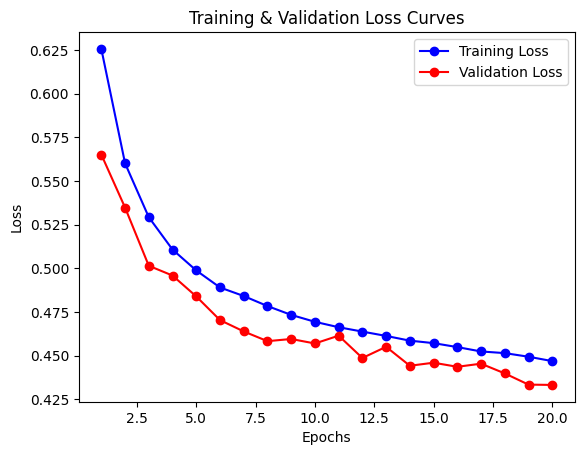

In [42]:
num_epochs = 20
learning_rate = 0.0005
num_heads = 5
hiddendim = 80
numlayers = 2
embeddingdim = 40

losses,finalmodel = train_model(num_epochs,learning_rate,train_loader,train_loader, num_heads, hiddendim, embeddingdim, numlayers, dropout = 0.2)
plot_losses(losses)

Next I test my data on the test set and see that it achieved around a 78 percent accuracy

In [46]:
finalmodel.eval()

# Assuming you have a DataLoader for the test dataset, named test_loader
# test_loader = ...

correct = 0
total = 0

# Iterate through the test dataset
with torch.no_grad():  # Disable gradient computation during inference
    for batch in test_loader:
        # Forward pass
        inputs = batch['data'].to(device)
        targets = batch['label'].to(device)
        targets = targets.type(torch.FloatTensor)
        outputs = finalmodel(inputs)
        targets = torch.argmax(targets, dim=1).to(device)


        # Get predictions
        predicted_labels = torch.argmax(outputs, dim=1)

        # Update counts
        true_labels = targets

        total += len(true_labels)

        correct += (predicted_labels == true_labels).sum().item()



# Compute accuracy
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

<ipython-input-34-a1a8fb0b13a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [torch.tensor(item['data']) for item in batch]


Test Accuracy: 78.08%
